In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2425 sha256=f087fc18b8d5956ff8586e48b7ab7e88fb750e61b6c033e547e7860199f1f038
  Stored in directory: /root/.cache/pip/wheels/54/1d/51/d65a99106096dd07e3be6f08d5d3c2dd5f26ac98f626e5efc9
Successfully built colabgymrender


In [3]:
from colabgymrender.recorder import Recorder

  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



In [4]:
# install dependencies
!apt install chromium-browser xvfb

  and should_run_async(code)



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfontenc1 libfuse3-3 liblzo2-2 libudev1 libxfont2 libxkbfile1 snapd squashfs-tools
  systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfontenc1 libfuse3-3 liblzo2-2 libxfont2 libxkbfile1 snapd
  squashfs-tools systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
The following packages will be upgraded:
  libudev1
1 upgraded, 17 newly installed, 0 to remove and 44 not upgraded.
Need to get 36.2 MB of archives.
After this operation, 129 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.3 [595 kB]


# CarPole-v0

In [5]:
env1 = gym.make('CartPole-v0')


  logger.warn(

  deprecation(

  deprecation(



In [7]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [9]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [105]:
def dqn_training(env,
                 net,
                 max_num_steps,
                 max_epsilon,
                 min_epsilon,
                 num_epsilon_decay_intervals,
                 gamma,
                 lr,
                 memory,
                 batch_size,
                 min_replay_size):
    q_net = net(env)
    target_net = net(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [107]:
rewards1, q_net1 = dqn_training(env=env1,
                                net=NeuralNetwork,
                                max_num_steps=50000,
                                max_epsilon=1.0,
                                min_epsilon=0.1,
                                num_epsilon_decay_intervals=10000,
                                gamma=0.99,
                                lr=alpha,
                                memory=50000,
                                batch_size=32,
                                min_replay_size=1000)

Episode: 43 Step: 1000 Average reward: 22.976744186046513
Episode: 90 Step: 2000 Average reward: 22.122222222222224
Episode: 132 Step: 3000 Average reward: 21.62
Episode: 168 Step: 4000 Average reward: 24.22
Episode: 198 Step: 5000 Average reward: 28.51
Episode: 228 Step: 6000 Average reward: 31.52
Episode: 253 Step: 7000 Average reward: 34.63
Episode: 273 Step: 8000 Average reward: 38.26
Episode: 289 Step: 9000 Average reward: 42.37
Episode: 298 Step: 10000 Average reward: 48.27
Episode: 305 Step: 11000 Average reward: 57.19
Episode: 311 Step: 12000 Average reward: 65.29
Episode: 317 Step: 13000 Average reward: 72.95
Episode: 323 Step: 14000 Average reward: 81.21
Episode: 328 Step: 15000 Average reward: 89.59
Episode: 333 Step: 16000 Average reward: 98.05
Episode: 338 Step: 17000 Average reward: 106.49
Episode: 343 Step: 18000 Average reward: 113.54
Episode: 348 Step: 19000 Average reward: 121.32
Episode: 353 Step: 20000 Average reward: 129.48
Episode: 358 Step: 21000 Average reward: 

In [94]:
def plot(rewards, title=None, figsize=(10, 6)):
    rewards = np.array(rewards)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel('Steps')
    plt.ylabel('Score')
    plt.plot(rewards[:, 0], rewards[:, 1])
    plt.show()

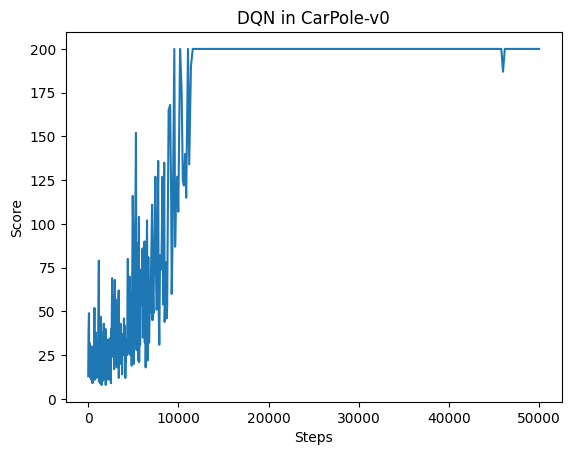

In [13]:
plot(rewards1, "DQN in CarPole-v0")

In [17]:
def video_builder(env, filename=None, q_net=None):
  env = Recorder(env, './video')
  state = env.reset()
  done = False
  total_reward = 0.0

  if not q_net:
    while not done:
        action = env1.action_space.sample()
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state
  else:
    q_net.eval()
    with torch.no_grad():
        while not done:
            #action = env.action_space.sample()
            action = q_net.choose_action(state)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state

  print("Total reward: ",total_reward)
  return env

In [18]:
vid = video_builder(env1)
vid.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Total reward:  19.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  67%|██████▋   | 14/21 [00:00<00:00, 136.11it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1717071131.3140883.mp4, 720000 bytes wanted but 0 bytes read,at frame 20/21, at time 0.67/0.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                             

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [19]:
vid = video_builder(env1,
                    q_net=q_net1)
vid.play()

  and should_run_async(code)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Total reward:  200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# MountainCar-v0

In [74]:
env2 = gym.make('MountainCar-v0')

  deprecation(

  deprecation(



In [82]:
class MountainCarNet(nn.Module):
    def __init__(self, env):
        super(MountainCarNet, self).__init__()
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.network = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, self.action_size)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

  and should_run_async(code)



In [110]:
rewards2, q_net2 = dqn_training(env=env2,
                                net=MountainCarNet,
                                max_num_steps=200000,
                                max_epsilon=1.0,
                                min_epsilon=0.01,
                                num_epsilon_decay_intervals=200,
                                gamma=0.999,
                                lr=0.001,
                                memory=50000,
                                batch_size=128,
                                min_replay_size=100)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0
Episode: 65 Step: 13000 Average reward: -200.0
Episode: 70 Step: 14000 Average reward: -200.0
Episode: 75 Step: 15000 Average reward: -200.0
Episode: 80 Step: 16000 Average reward: -200.0
Episode: 85 Step: 17000 Average reward: -200.0
Episode: 90 Step: 18000 Average reward: -200.0
Episode: 95 Step: 19000 Average reward: -200.0
Episode: 100 Step: 20000 Average reward: -200.0
Episode: 105 Step: 21000 Average reward: -200.0
Episode: 110 Step: 22

In [121]:
q_net2

MountainCarNet(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

# Report

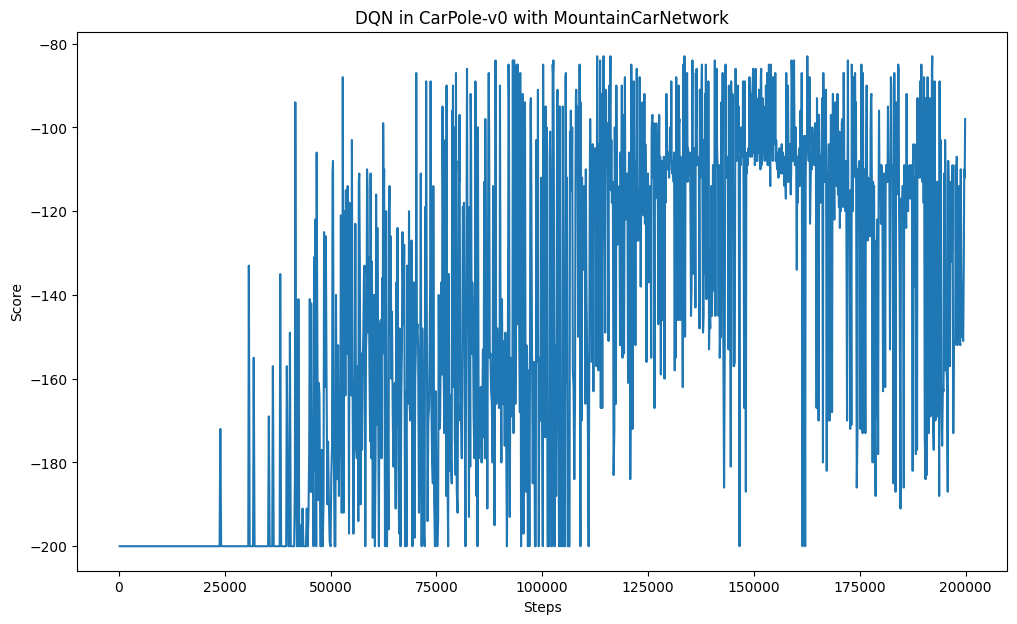

In [119]:
plot(rewards2, "DQN in CarPole-v0 with MountainCarNetwork", figsize=(12,7))

In [120]:
vid = video_builder(env2, q_net=q_net2)
vid.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Total reward:  -107.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Hyperparameters changes

*max_num_steps*: 50000 => 250000

*epsilon_decay_intervals*: 10000 => 200

*gamma*: 0.99 => 0.999

*alpha*: 5e-4 => 0.001

*min_replay_size*: 1000 => 100

*batch_size*: 32 => 128

## Neural Network changes

Adding:
- 1 more hiddenlayer
- change Tanh() into ReLU()
```
class MountainCarNet(nn.Module):
    def __init__(self, env):
        super(MountainCarNet, self).__init__()
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.network = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, self.action_size)
        )
```


